In [1]:
import SIMSIToolBox
import matplotlib.pyplot as plt
import os
import pandas as pd
import numpy as np
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from copy import deepcopy
import umap
from sklearn.cluster import KMeans

In [2]:
datadir = "X:/Kevin/Bruker/MALDI/imzML/"

In [3]:
fn = "brain_c12_nedc_neg_40um.imzML"

In [4]:
peaklist = pd.read_csv(datadir + "metaspace_annotations_NEDC_12C_40um.csv",header=2)
peaklist

,group,datasetName,datasetId,formula,adduct,chemMod,ion,mz,msm,fdr,...,moleculeNames,moleculeIds,minIntensity,maxIntensity,totalIntensity,isomers,isobars,offSample,rawOffSampleProb,isobarIons
0,NaN,40um-NEDC-maldi1,2022-09-23_14h13m33s,C4H6O4,M-H,NaN,C4H6O4-H-,117.019254,0.094677,0.20,...,"Erythrono-1,4-lactone, Methylmalonic acid, Suc...","HMDB0000349, HMDB0000202, HMDB0000254, HMDB000...",0,1222,1809174,7,1,False,0.037365,C5H8OS-H-
1,NaN,40um-NEDC-maldi1,2022-09-23_14h13m33s,C8H8O,M-H,NaN,C8H8O-H-,119.050160,0.070906,0.20,...,"4-Hydroxystyrene, Phenylacetaldehyde, 2,3-Dihy...","HMDB0004072, HMDB0006236, HMDB0013815, HMDB002...",0,510,409673,10,0,False,0.000045,NaN
2,NaN,40um-NEDC-maldi1,2022-09-23_14h13m33s,C2H7NO3S,M-H,NaN,C2H7NO3S-H-,124.007309,0.654689,0.05,...,Taurine,HMDB0000251,0,64368,1072943616,1,0,False,0.000191,NaN
3,NaN,40um-NEDC-maldi1,2022-09-23_14h13m33s,C5H6N2O2,M-H,NaN,C5H6N2O2-H-,125.035573,0.075157,0.20,...,"1H-Imidazole-1-acetic acid, Thymine, Imidazole...","HMDB0029736, HMDB0000262, HMDB0002024",0,1074,1970451,3,1,False,0.000011,C6H9NS-H-
4,NaN,40um-NEDC-maldi1,2022-09-23_14h13m33s,C6H9NO2,M-H,NaN,C6H9NO2-H-,126.055974,0.080558,0.20,...,"D-1-Piperideine-2-carboxylic acid, (S)-2,3,4,5...","HMDB0001084, HMDB0012130, HMDB0029434, HMDB005...",0,1006,5709366,4,1,False,0.000108,C5H7N3O-H-
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
286,NaN,40um-NEDC-maldi1,2022-09-23_14h13m33s,C21H27ClO5,M-H,NaN,C21H27ClO5-H-,393.147347,0.063647,0.20,...,Loteprednol,HMDB0015011,0,575,3060715,1,1,False,0.000129,C16H26O11-H-
287,NaN,40um-NEDC-maldi1,2022-09-23_14h13m33s,C18H37O7P,M-H,NaN,C18H37O7P-H-,395.220335,0.066379,0.20,...,"(9S,10S)-10-hydroxy-9-(phosphonooxy)octadecano...","HMDB0059632, HMDB0062324",0,288,204303,2,2,False,0.000058,"C24H31NO4-H-, C25H30O4-H-"
288,NaN,40um-NEDC-maldi1,2022-09-23_14h13m33s,C24H31NO4,M-H,NaN,C24H31NO4-H-,396.217954,0.074164,0.20,...,Drotaverine,HMDB0015669,0,265,202889,1,3,False,0.000179,"C21H32O7-H-, C18H37O7P-H-, C23H30N2O4-H-"
289,NaN,40um-NEDC-maldi1,2022-09-23_14h13m33s,C24H30O5,M-H,NaN,C24H30O5-H-,397.201969,0.072374,0.20,...,"Galbanic acid, Armillaribin, Mammea C/AB cyclo...","HMDB0030163, HMDB0031672, HMDB0033881, HMDB003...",0,307,196509,6,3,False,0.000161,"C17H32O10-H-, C22H27FN4O2-H-, C23H30ClN3O-H-"


In [5]:
mzs = []
keys = []
for index,row in peaklist.iterrows():
    _,_,nC = SIMSIToolBox.getMzsOfIsotopologues(row["formula"],"C")
    for x in range(nC+1):
        mzs.append(row["mz"] + 1.00336 * x)
        keys.append((index,x))
print(len(mzs))

4236


In [6]:
ppmThresh = 10
num_cores = 20
intensityCutoff = 100
convSquare = 3 #size of filter (1=1x1,3=3x3,5=5x5)
colormap = LinearSegmentedColormap.from_list("test",colors=["black", "navy","blue","cyan","yellow","orange","orangered","red","mistyrose","white"],N=256)
dm_method = "PCA" #method for dimensionality reduction ("PCA" or "TSNE") PCA has worked better for me
seg_method = "K_means" #thresholding method ("TIC_auto", "K_means", "TIC_manual")
num_components = 2 #number of compoents to use with PCA or TSNE
filt = "GB" #filtering method (GB = gaussian blur, MA = moving average)

In [7]:
msi = SIMSIToolBox.MSIData(mzs,ppm=ppmThresh,numCores = num_cores,intensityCutoff=intensityCutoff)

In [8]:
if __name__ == "__main__":
    msi.readimzML(datadir+fn)

c:\users\ethan\appdata\local\programs\python\python37\lib\site-packages\pyimzml\ontology\ontology.py:94: UserWarning: Accession IMS:1000046 found with incorrect name "pixel size x". Updating name to "pixel size (x)".
  % (accession, raw_name, name)


extracting intensities |██████████████████████████████████████████████████| 100.0% 


In [ ]:
if __name__ == "__main__":
    msi.segmentImage(method=seg_method)

In [ ]:
if __name__ == "__main__":
    msi.smoothData(filt,convSquare)

In [ ]:
msi_corrected = deepcopy(msi)

In [ ]:
if __name__ == "__main__":
    for index,row in peaklist.iterrows():
        inds = [x for x in range(len(keys)) if keys[x][0] == index]
        inds.sort(key=lambda x: keys[x][1])
        tmp = msi.data_tensor[inds]
        poolSize = np.sum(tmp[:1] / msi.tic_image, axis=0)

        msi_corrected.correctNaturalAbundance(row["formula"],inds)
        tmp = msi_corrected.data_tensor[inds]
        isoTensor = SIMSIToolBox.normalizeTensor(tmp)
        plt.figure()
        SIMSIToolBox.showImage(poolSize, cmap=colormap)
        plt.title(row["moleculeNames"])
        plt.figure()
        SIMSIToolBox.showImage(isoTensor[0], cmap=colormap)
        plt.title(row["moleculeNames"])
        if np.mean(isoTensor[0][msi.background ) < 
    

In [52]:
poolsizeTensor = []
targs = []
for index,row in peaklist.iterrows():
    inds = [x for x in range(len(keys)) if keys[x][0] == index]
    inds.sort(key=lambda x: keys[x][1])
    poolsizeTensor.append(msi.data_tensor[inds[0]])
    targs.append(msi.targets[inds[0]])

In [53]:
msi_pool = deepcopy(msi)

In [54]:
msi_pool.data_tensor = np.array(poolsizeTensor)
msi_pool.targets = targs

In [55]:
format_data = msi_pool.to_pandas()
xs = format_data["x"].values
ys = format_data["y"].values
format_data = format_data[msi_pool.targets].to_numpy()

In [56]:
format_data.shape

(50034, 291)

In [57]:
fit = umap.UMAP()
u = fit.fit_transform(format_data)

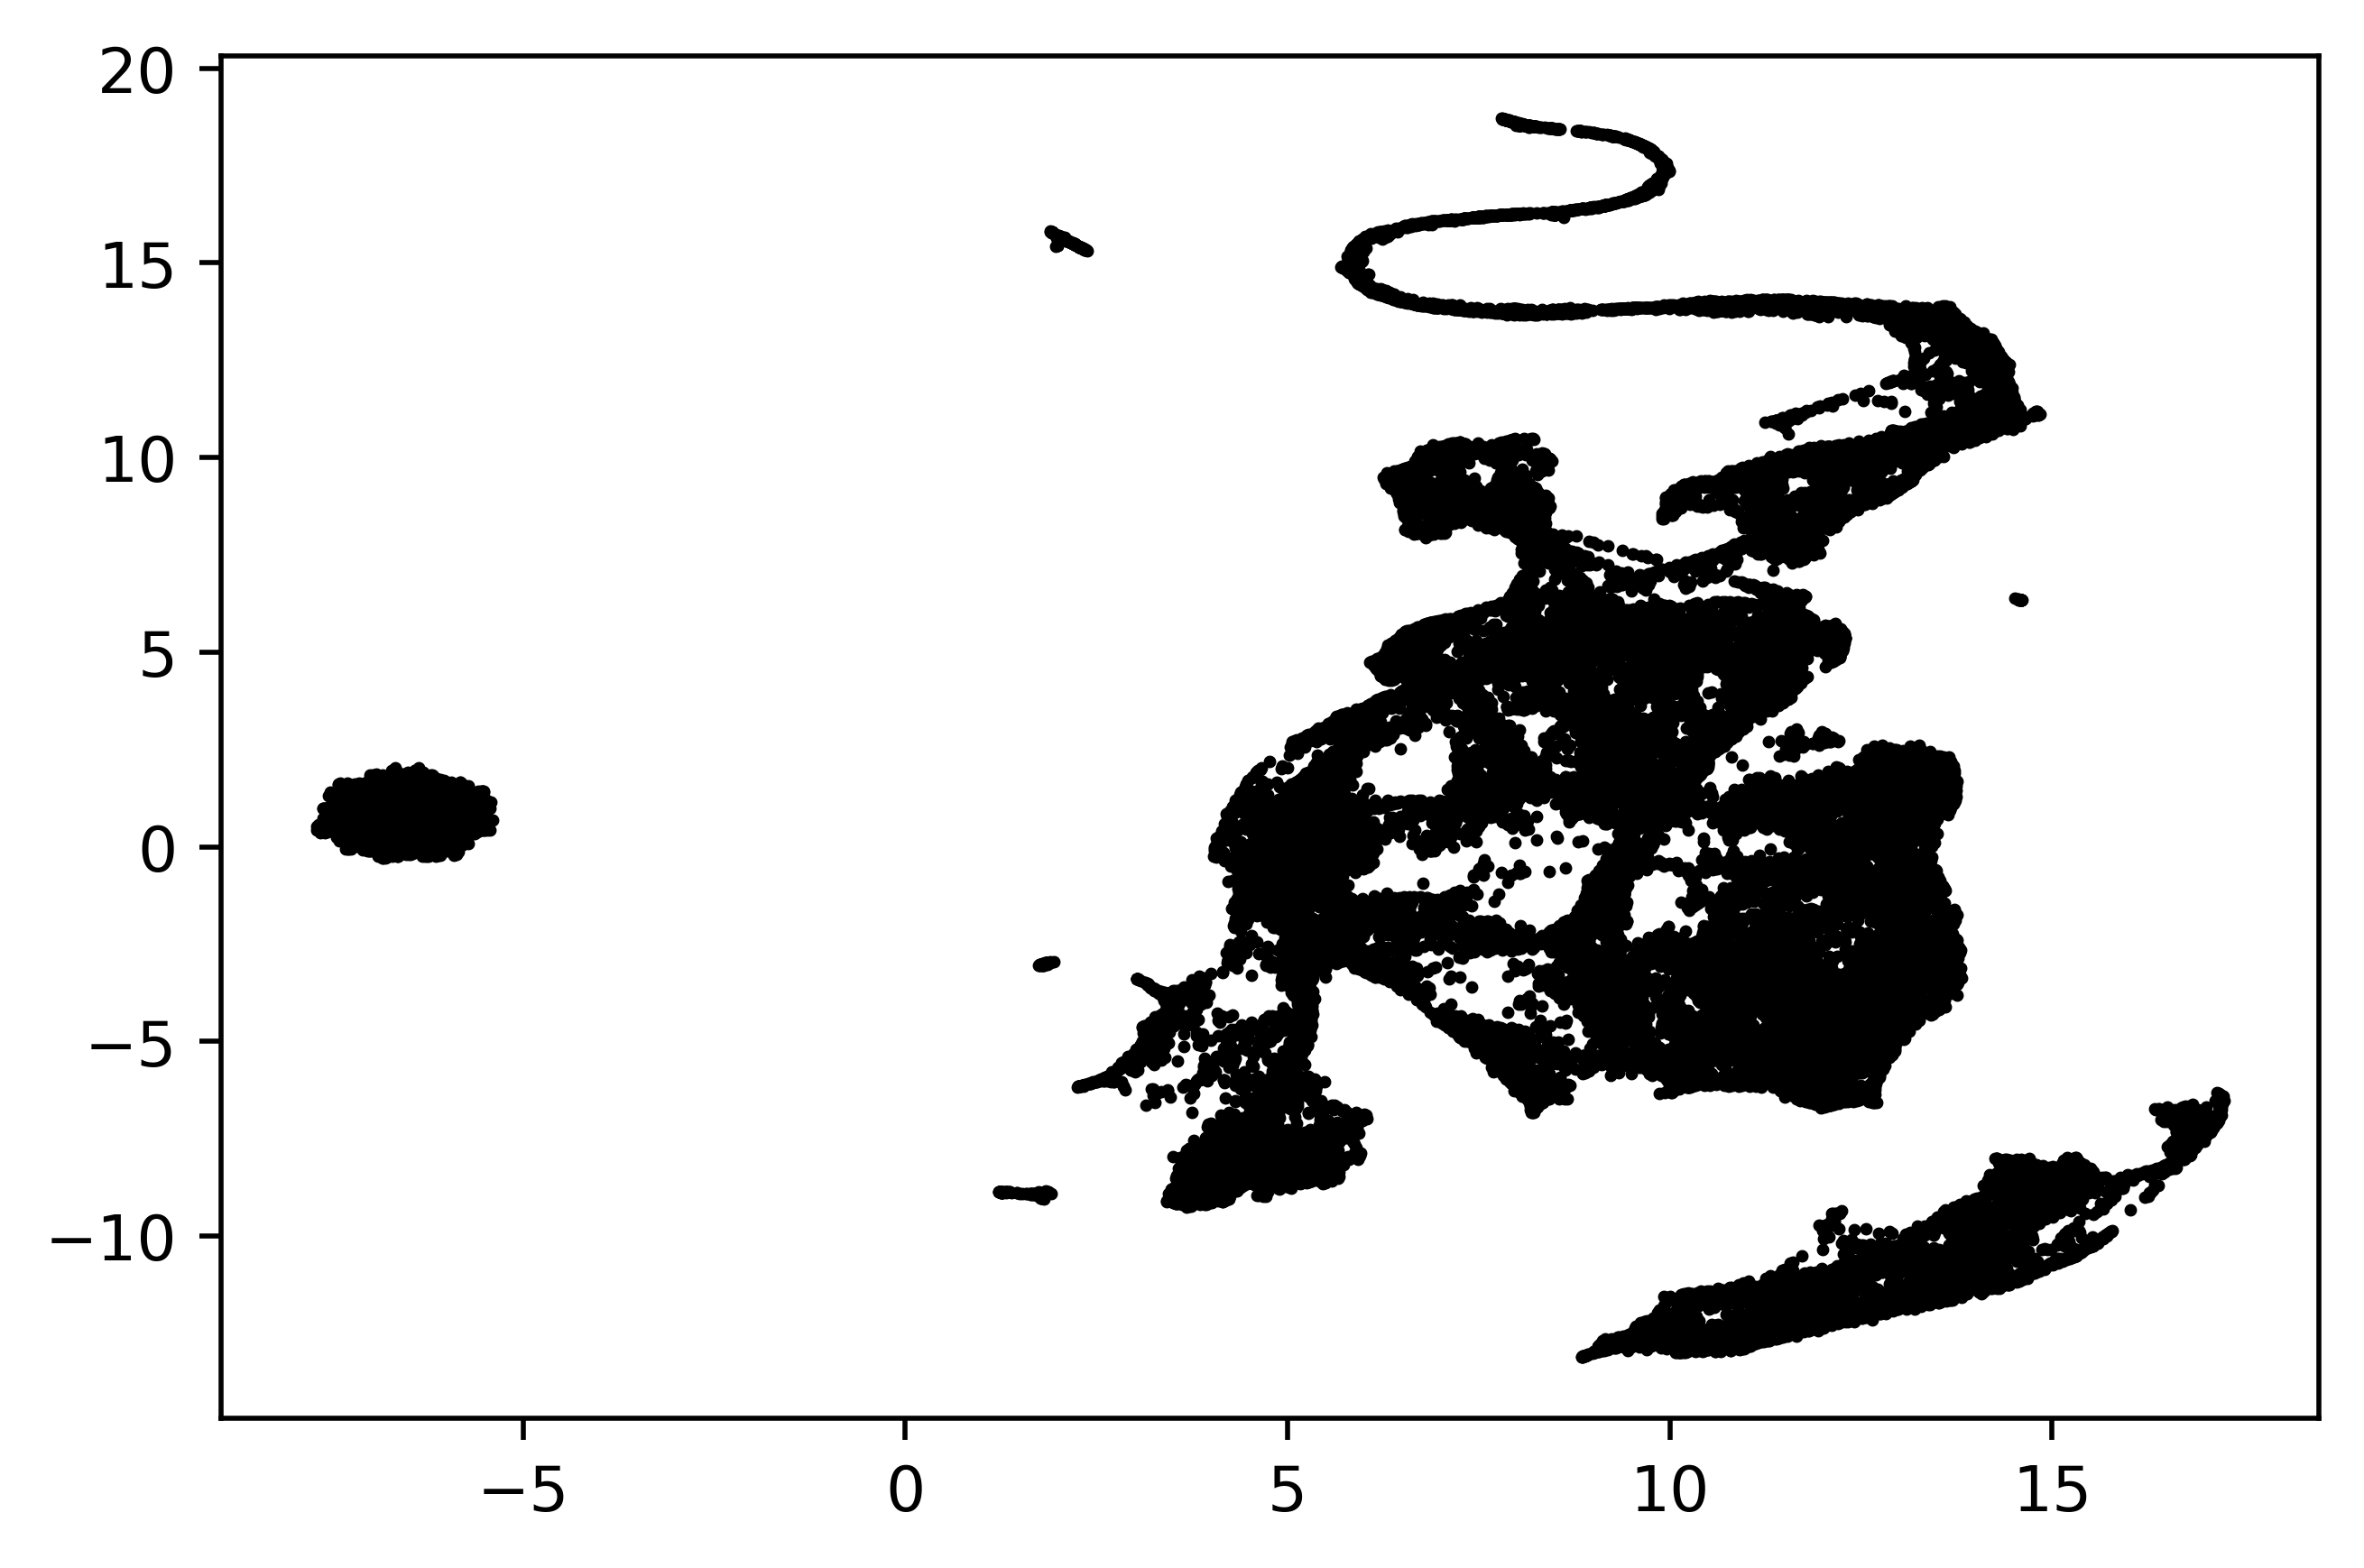

In [58]:
plt.scatter(u[:,0], u[:,1],c="black",s=1)


In [59]:
kmeans_labels = KMeans(n_clusters=8).fit_predict(u)

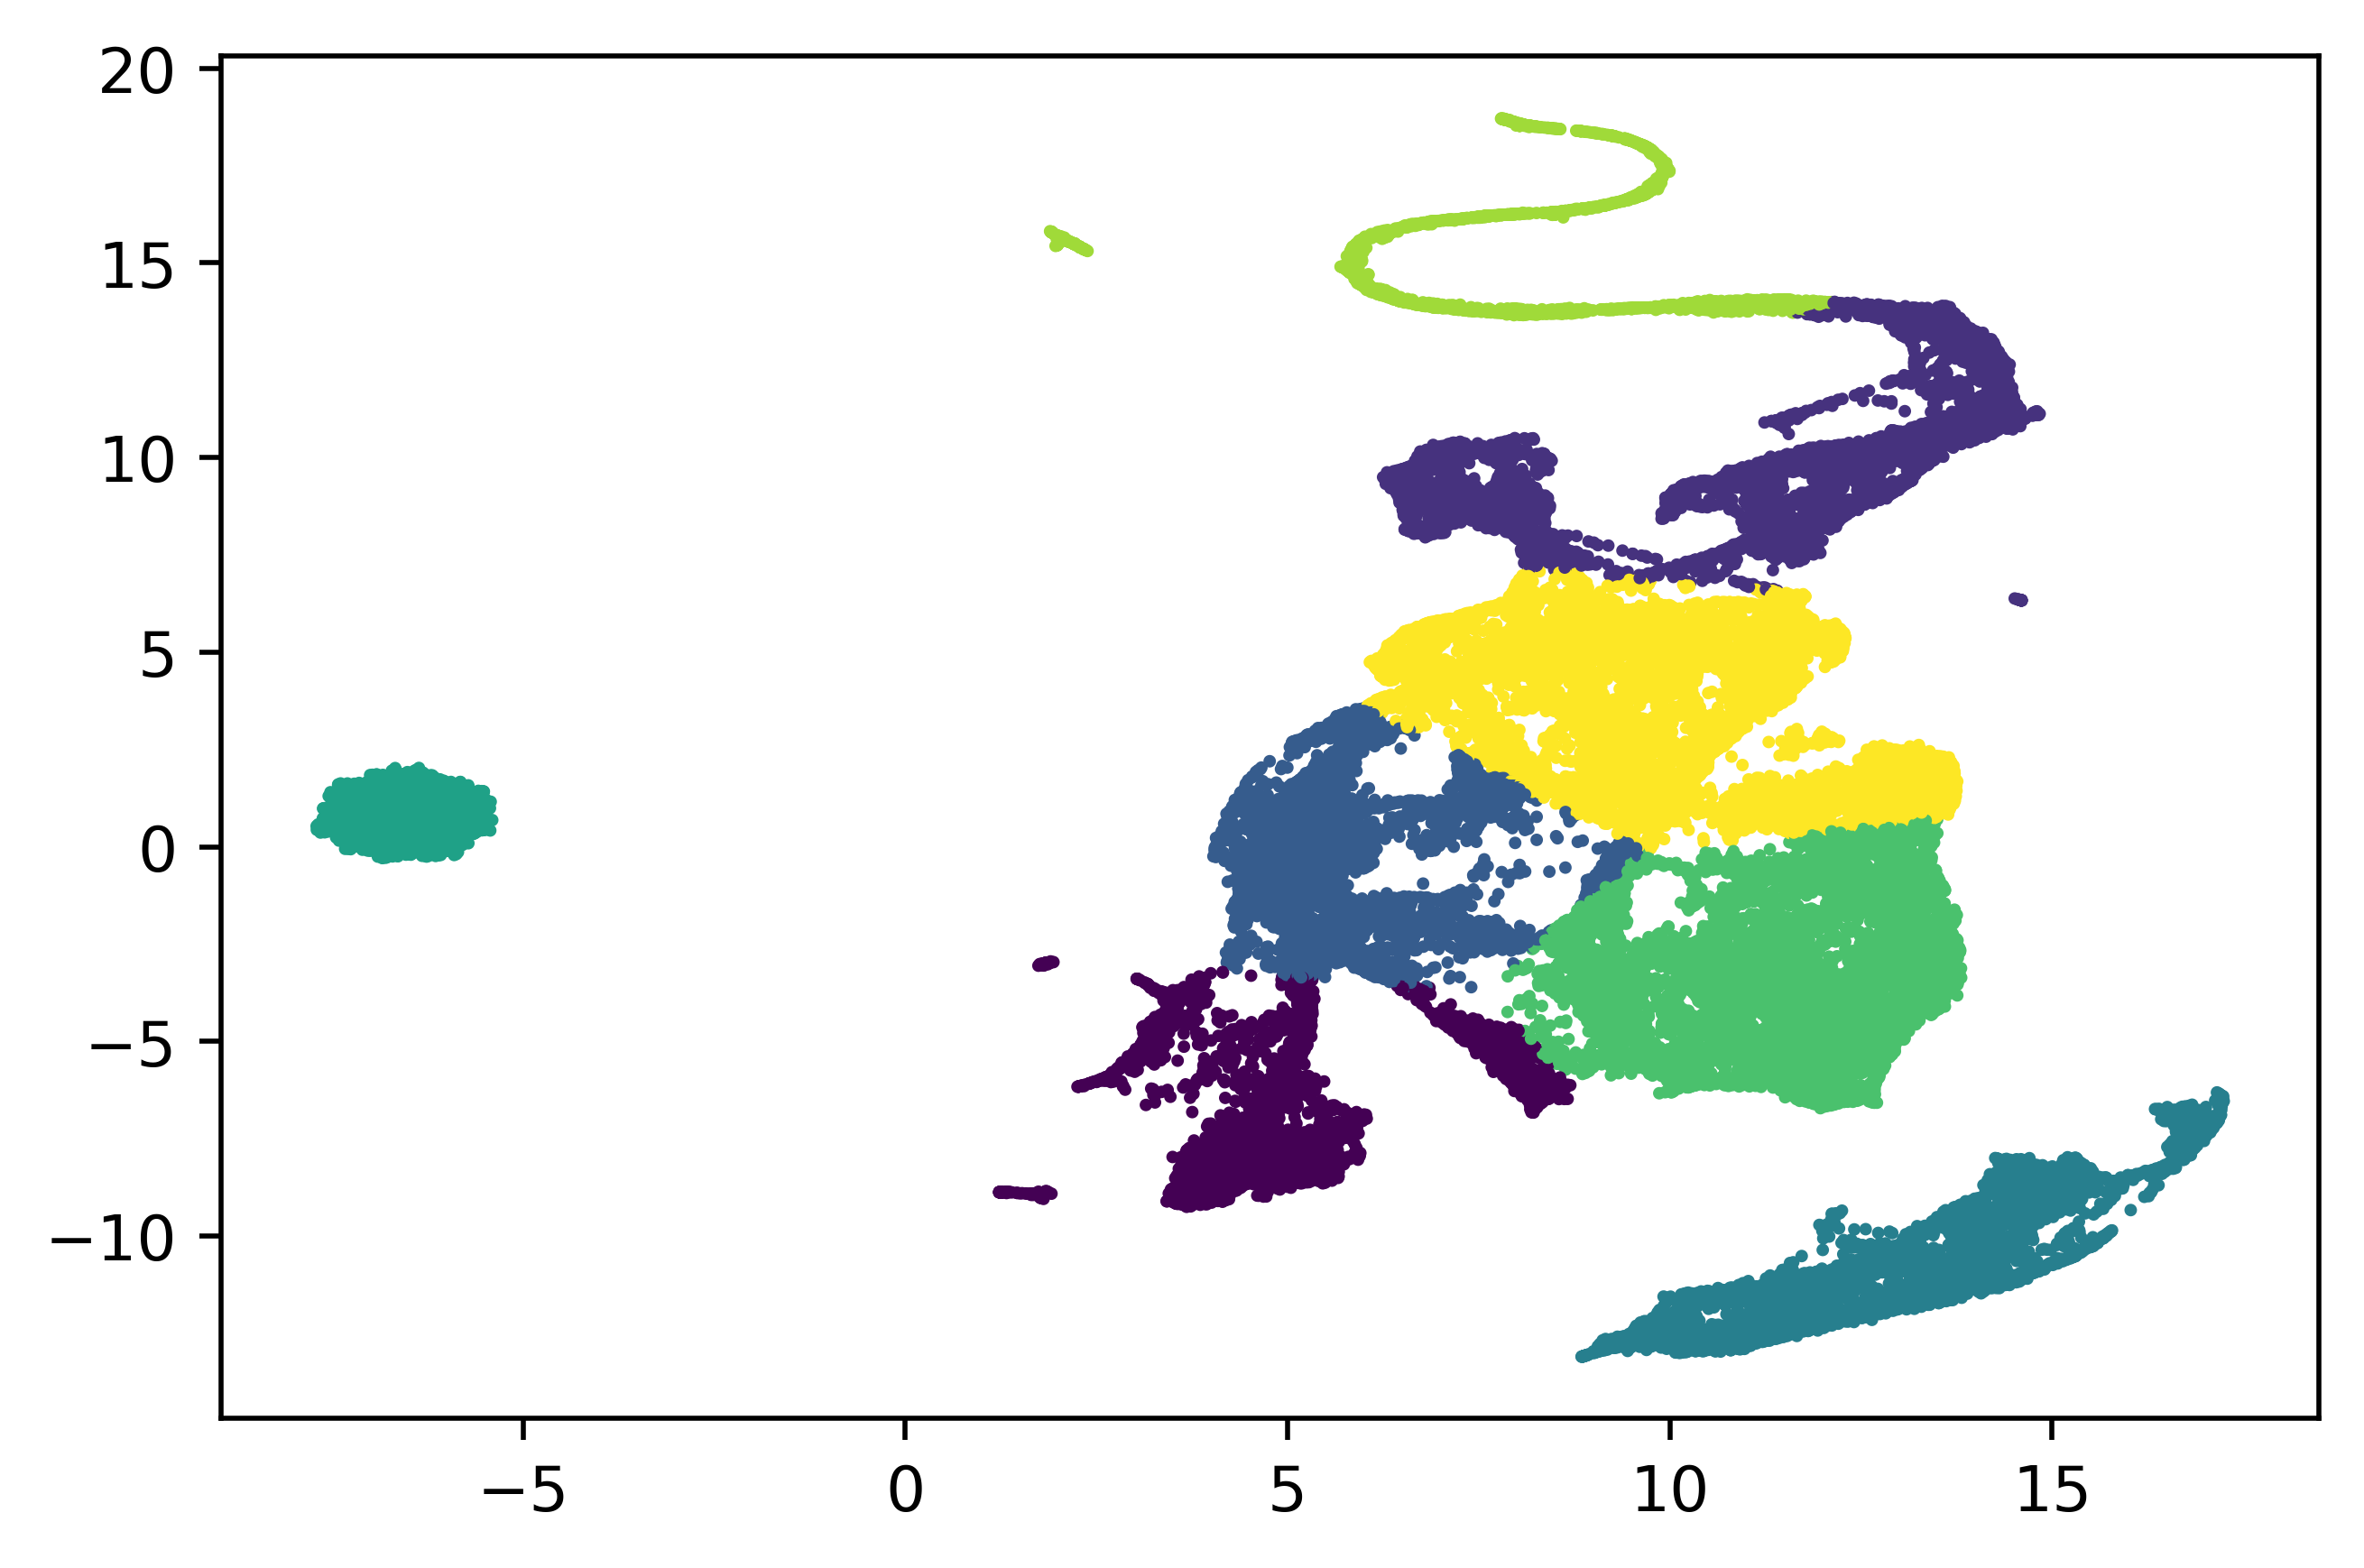

In [60]:
plt.scatter(u[:,0], u[:,1],c=kmeans_labels,s=1)

In [61]:
df = pd.DataFrame()
df["x"] = xs
df["y"] = ys
df["cluster"] = kmeans_labels
df["comp1"] = u[:,0]
df["comp2"] = u[:,1]
df

,x,y,cluster,comp1,comp2
0,0,0,4,-6.570827,0.646470
1,1,0,4,-6.261268,1.589771
2,2,0,4,-6.005578,0.645706
3,3,0,4,-6.023043,1.544511
4,4,0,4,-6.579461,1.184941
...,...,...,...,...,...
50029,264,185,4,-6.201488,0.246018
50030,265,185,4,-6.489655,-0.081019
50031,266,185,4,-6.684782,1.169815
50032,267,185,4,-5.520367,0.579039


In [63]:
umapImg = SIMSIToolBox.MSIData.parse_df_to_matrix(df,["cluster"],-1,(msi_pool.data_tensor[0].shape[0],msi_pool.data_tensor[0].shape[1]))

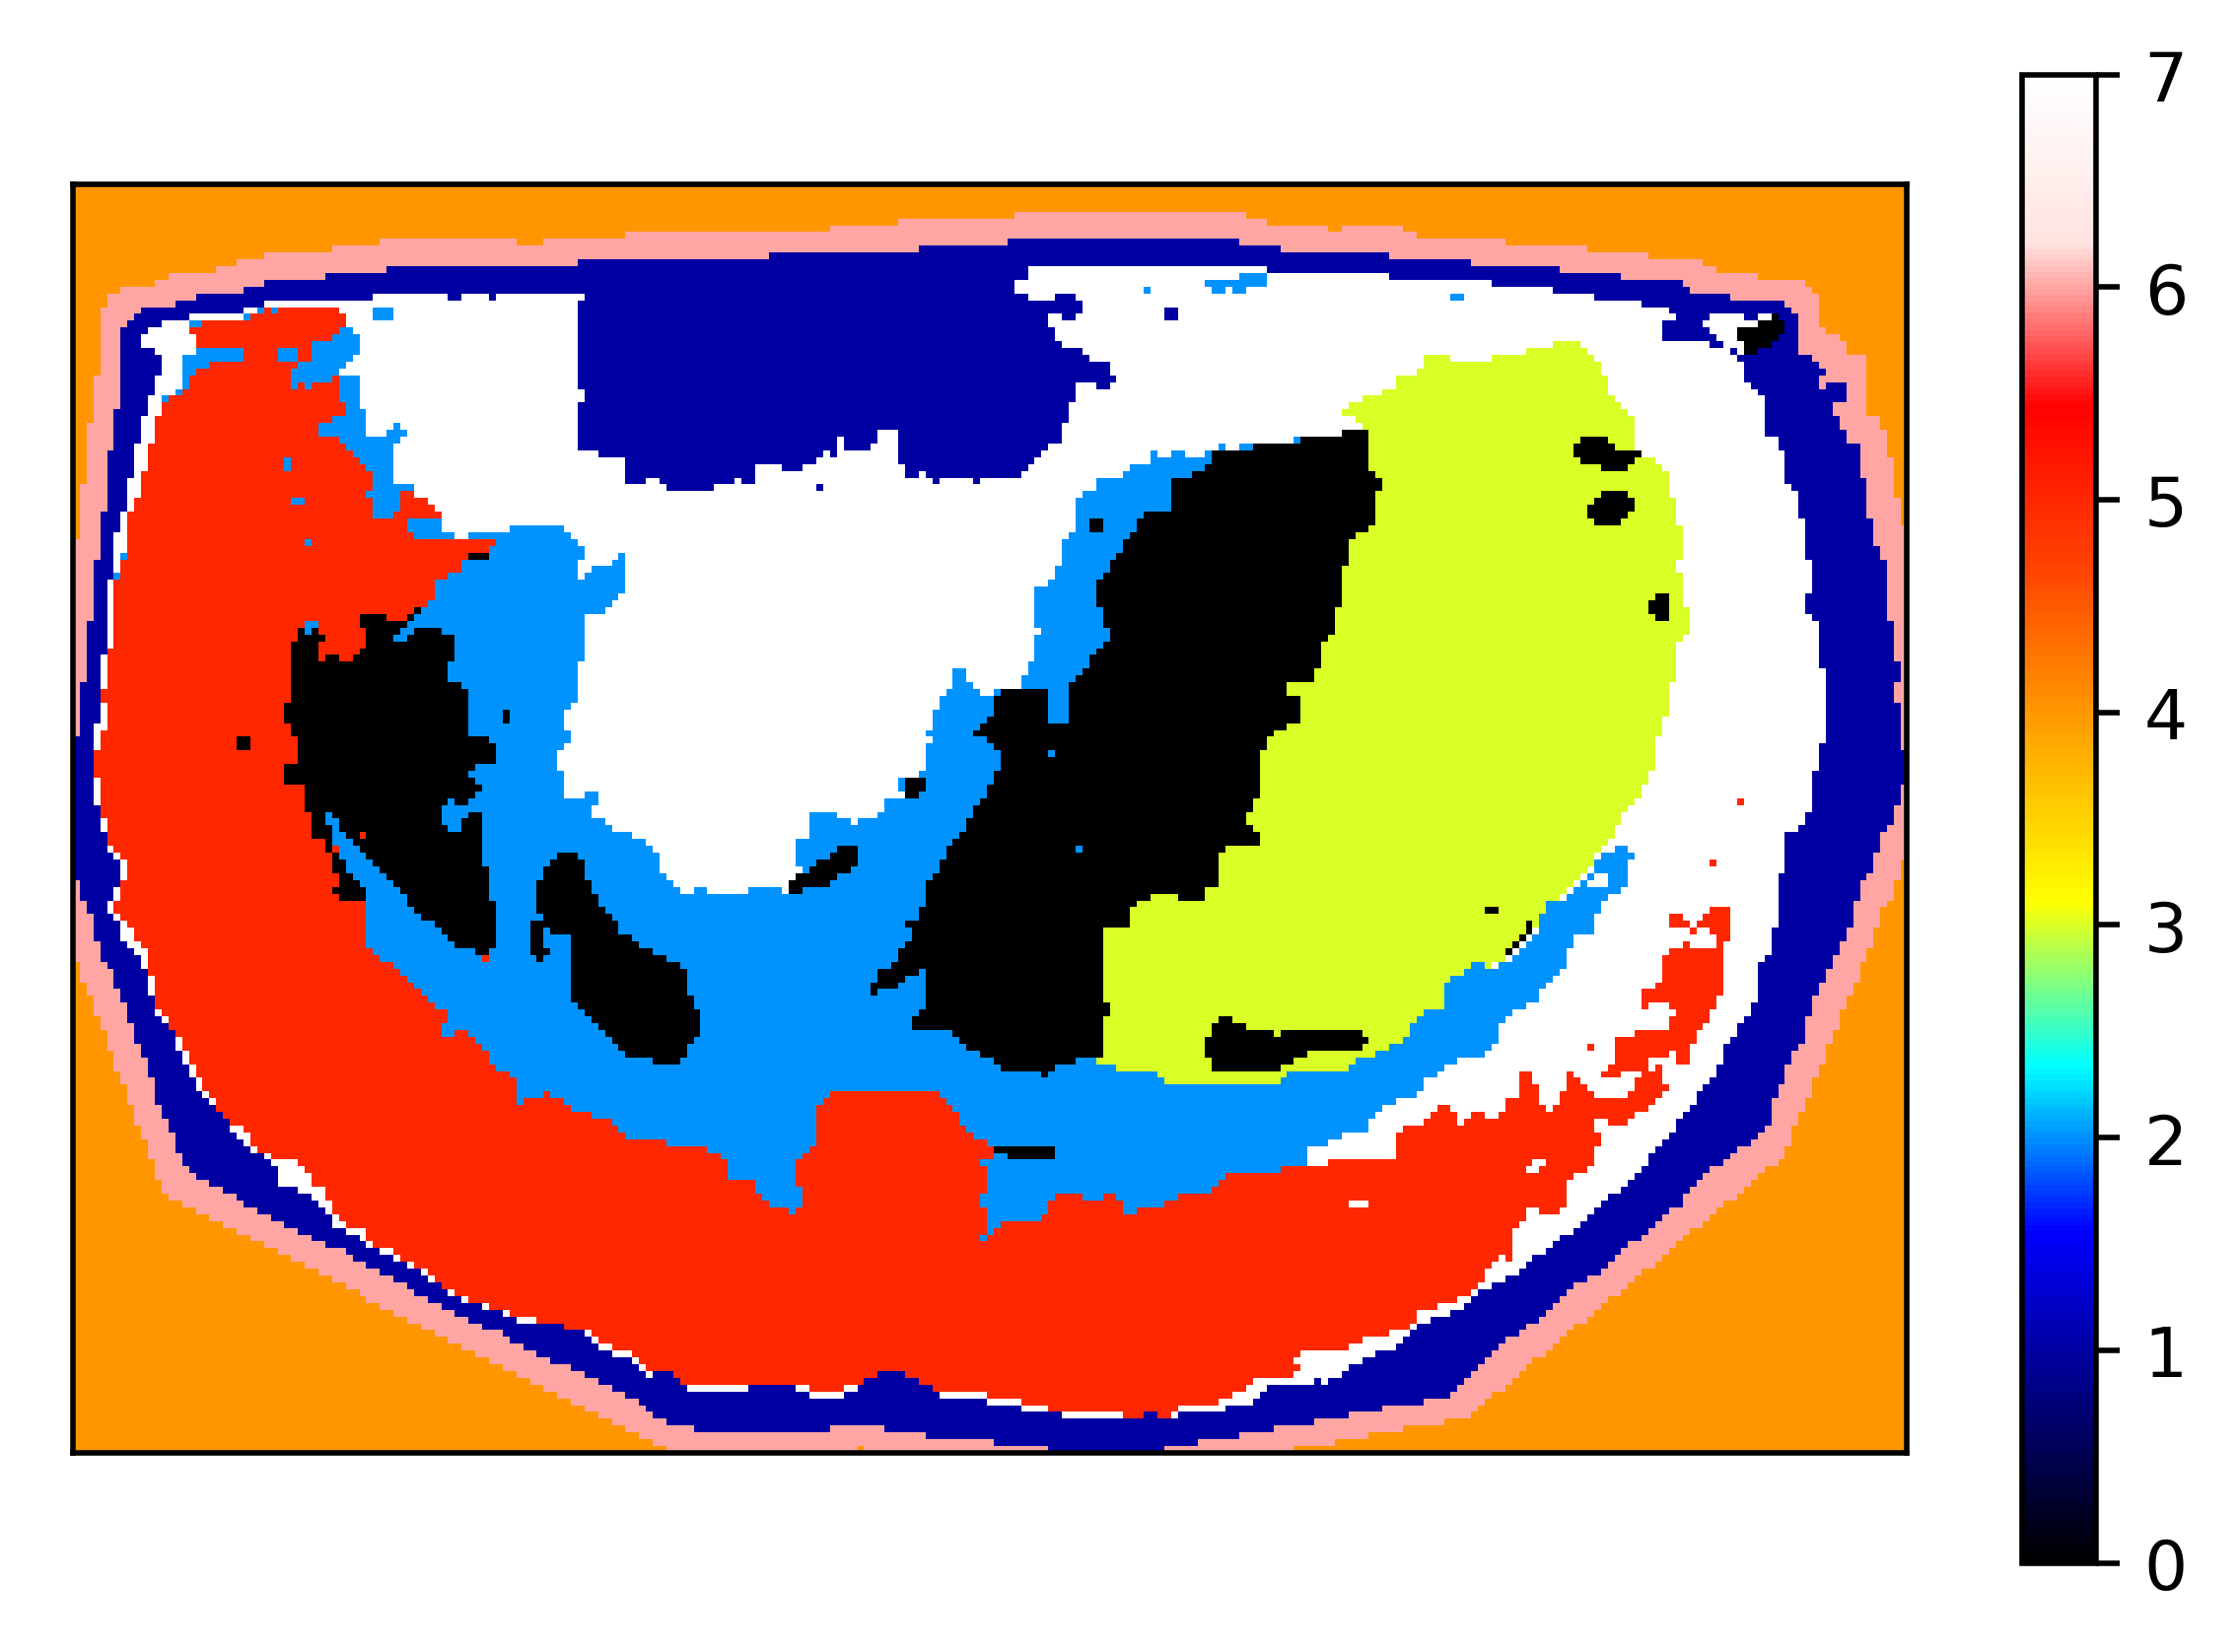

In [65]:
SIMSIToolBox.showImage(umapImg, cmap=colormap)